In [1]:
from typing import Tuple, Union, Optional, List

import torch
import torch.nn as nn
from torch.optim.adamw import AdamW
from torch.optim.sgd import SGD
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
import transformers
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display, clear_output

T = torch.Tensor
TN = Optional[T]
TS = Union[Tuple[T, ...], List[T]]

device = torch.device('cuda:0')


## Delta Denoising Score: zero-shot image editing

In [2]:
def load_512(image_path: str, left=0, right=0, top=0, bottom=0):
    image = np.array(Image.open(image_path))[:, :, :3]    
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image


@torch.no_grad()
def get_text_embeddings(pipe: StableDiffusionPipeline, text: str) -> T:
    tokens = pipe.tokenizer([text], padding="max_length", max_length=77, truncation=True,
                                   return_tensors="pt", return_overflowing_tokens=True).input_ids.to(device)
    return pipe.text_encoder(tokens).last_hidden_state.detach()

@torch.no_grad()
def denormalize(image):
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).astype(np.uint8)
    return image[0]


@torch.no_grad()
def decode(latent: T, pipe: StableDiffusionPipeline, im_cat: TN = None):
    image = pipeline.vae.decode((1 / 0.18215) * latent, return_dict=False)[0]
    image = denormalize(image)
    if im_cat is not None:
        image = np.concatenate((im_cat, image), axis=1)
    return Image.fromarray(image)

In [3]:

def init_pipe(device, dtype, unet, scheduler) -> Tuple[UNet2DConditionModel, T, T]:

    with torch.inference_mode():
        alphas = torch.sqrt(scheduler.alphas_cumprod).to(device, dtype=dtype)
        sigmas = torch.sqrt(1 - scheduler.alphas_cumprod).to(device, dtype=dtype)
    for p in unet.parameters():
        p.requires_grad = False
    return unet, alphas, sigmas


class DDSLoss:
 
    def noise_input(self, z, eps=None, timestep: Optional[int] = None):
        if timestep is None:
            b = z.shape[0]
            timestep = torch.randint(
                low=self.t_min,
                high=min(self.t_max, 1000) - 1,  # Avoid the highest timestep.
                size=(b,),
                device=z.device, dtype=torch.long)
        if eps is None:
            eps = torch.randn_like(z)
        alpha_t = self.alphas[timestep, None, None, None]
        sigma_t = self.sigmas[timestep, None, None, None]
        z_t = alpha_t * z + sigma_t * eps
        return z_t, eps, timestep, alpha_t, sigma_t

    def get_eps_prediction(self, z_t: T, timestep: T, text_embeddings: T, alpha_t: T, sigma_t: T, get_raw=False,
                           guidance_scale=7.5):

        latent_input = torch.cat([z_t] * 2)
        timestep = torch.cat([timestep] * 2)
        embedd = text_embeddings.permute(1, 0, 2, 3).reshape(-1, *text_embeddings.shape[2:])
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            e_t = self.unet(latent_input, timestep, embedd).sample
            if self.prediction_type == 'v_prediction':
                e_t = torch.cat([alpha_t] * 2) * e_t + torch.cat([sigma_t] * 2) * latent_input
            e_t_uncond, e_t = e_t.chunk(2)
            if get_raw:
                return e_t_uncond, e_t
            e_t = e_t_uncond + guidance_scale * (e_t - e_t_uncond)
            assert torch.isfinite(e_t).all()
        if get_raw:
            return e_t
        pred_z0 = (z_t - sigma_t * e_t) / alpha_t
        return e_t, pred_z0

    def get_sds_loss(self, z: T, text_embeddings: T, eps: TN = None, mask=None, t=None,
                 timestep: Optional[int] = None, guidance_scale=7.5) -> TS:
        with torch.inference_mode():
            z_t, eps, timestep, alpha_t, sigma_t = self.noise_input(z, eps=eps, timestep=timestep)
            e_t, _ = self.get_eps_prediction(z_t, timestep, text_embeddings, alpha_t, sigma_t,
                                             guidance_scale=guidance_scale)
            grad_z = (alpha_t ** self.alpha_exp) * (sigma_t ** self.sigma_exp) * (e_t - eps)
            assert torch.isfinite(grad_z).all()
            grad_z = torch.nan_to_num(grad_z.detach(), 0.0, 0.0, 0.0)
            if mask is not None:
                grad_z = grad_z * mask
            log_loss = (grad_z ** 2).mean()
        sds_loss = grad_z.clone() * z
        del grad_z
        return sds_loss.sum() / (z.shape[2] * z.shape[3]), log_loss

  
    def get_dds_loss(self, z_source: T, z_target: T, text_emb_source: T, text_emb_target: T,
                            eps=None, reduction='mean', symmetric: bool = False, calibration_grad=None, timestep: Optional[int] = None,
                      guidance_scale=7.5, raw_log=False) -> TS:
        with torch.inference_mode():
            z_t_source, eps, timestep, alpha_t, sigma_t = self.noise_input(z_source, eps, timestep)
            z_t_target, _, _, _, _ = self.noise_input(z_target, eps, timestep)
            eps_pred, _ = self.get_eps_prediction(torch.cat((z_t_source, z_t_target)),
                                                  torch.cat((timestep, timestep)),
                                                  torch.cat((text_emb_source, text_emb_target)),
                                                  torch.cat((alpha_t, alpha_t)),
                                                  torch.cat((sigma_t, sigma_t)),
                                                  guidance_scale=guidance_scale)
            eps_pred_source, eps_pred_target = eps_pred.chunk(2)
            grad = (alpha_t ** self.alpha_exp) * (sigma_t ** self.sigma_exp) * (eps_pred_target - eps_pred_source)
            if calibration_grad is not None:
                if calibration_grad.dim() == 4:
                    grad = grad - calibration_grad
                else:
                    grad = grad - calibration_grad[timestep - self.t_min]
            if raw_log:
                log_loss = eps.detach().cpu(), eps_pred_target.detach().cpu(), eps_pred_source.detach().cpu()
            else:
                log_loss = (grad ** 2).mean()
        loss = z_target * grad.clone()
        if symmetric:
            loss = loss.sum() / (z_target.shape[2] * z_target.shape[3])
            loss_symm = self.rescale * z_source * (-grad.clone())
            loss += loss_symm.sum() / (z_target.shape[2] * z_target.shape[3])
        elif reduction == 'mean':
            loss = loss.sum() / (z_target.shape[2] * z_target.shape[3])
        return loss, log_loss

    def __init__(self, device, pipe: StableDiffusionPipeline, dtype=torch.float32):
        self.t_min = 50
        self.t_max = 950
        self.alpha_exp = 0
        self.sigma_exp = 0
        self.dtype = dtype
        self.unet, self.alphas, self.sigmas = init_pipe(device, dtype, pipe.unet, pipe.scheduler)
        self.prediction_type = pipe.scheduler.prediction_type

In [4]:
model_id  =  ["runwayml/stable-diffusion-v1-5", "stabilityai/stable-diffusion-2-1"][0]
pipeline = StableDiffusionPipeline.from_pretrained(model_id,).to(device)

/home/user28/miniconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
def show_1(grad):
    plt.imshow((grad/ 2 + 0.5).cpu().permute(0, 2, 3, 1).numpy()[0].astype('uint8'))

In [6]:
def image_optimization(pipe: StableDiffusionPipeline, image: np.ndarray, text_source: str, text_target: str, image_n: np.ndarray, num_iters=200, use_dds=True) -> None:
    dds_loss = DDSLoss(device, pipe)
    image_source = torch.from_numpy(image).float().permute(2, 0, 1) / 127.5 - 1
    image_source = image_source.unsqueeze(0).to(device)

    image_target = torch.from_numpy(image_n).float().permute(2, 0, 1) / 127.5 - 1
    image_target = image_target.unsqueeze(0).to(device)
    with torch.no_grad():
        z_source = pipeline.vae.encode(image_source)['latent_dist'].mean * 0.18215
        z_noise = pipeline.vae.encode(image_target)['latent_dist'].mean * 0.18215


        
        image_target = image_target.clone()
        embedding_null = get_text_embeddings(pipeline, "")
        embedding_text = get_text_embeddings(pipeline, text_source)
        embedding_text_target = get_text_embeddings(pipeline, text_target)
        embedding_source = torch.stack([embedding_null, embedding_text], dim=1)
        embedding_target = torch.stack([embedding_null, embedding_text_target], dim=1)

    guidance_scale = 7.5
    image_target.requires_grad = True
    use_dds_loss = True

    z_taregt = z_noise.clone()
    z_taregt.requires_grad = True
    optimizer = SGD(params=[z_taregt], lr=1e-1)
    for i in tqdm(range(num_iters)):
        if use_dds:
            loss, log_loss = dds_loss.get_dds_loss(z_source, z_taregt, embedding_source, embedding_target)
            
        else:
            loss, log_loss = dds_loss.get_sds_loss(z_taregt, embedding_target)
        optimizer.zero_grad()
        (2000 * loss).backward()
        optimizer.step()
        if (i + 1) % 10 == 0:
            out = decode(z_taregt, pipeline)
            print(type(out))
            print(out.size)
            #out.save(f'img_test_save{i}.png')
            
            clear_output(wait=True)
            display(out)


### DDS image optimization

In [7]:
from torchvision import transforms
from PIL import Image

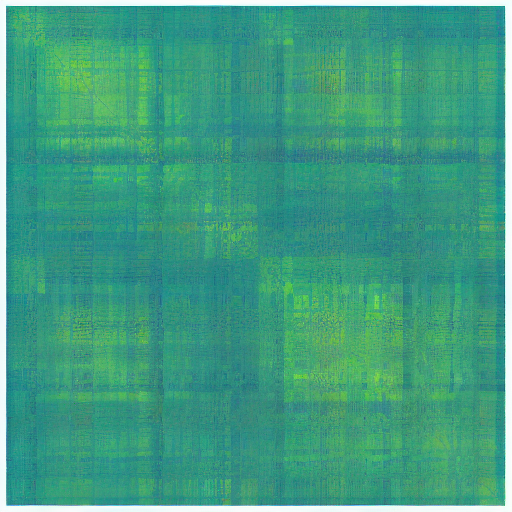

In [11]:
img_source = load_512("./fMRI/734045_rfMRI_REST1_LR.png")
img_target = load_512("./fMRI/734045_tfMRI_MOTOR_LR.png")
image_optimization(pipeline, img_source,"a pearson correlation matrix.", "a pearson correlation matrix.", img_target, num_iters=100, use_dds=True)

### SDS image optimization

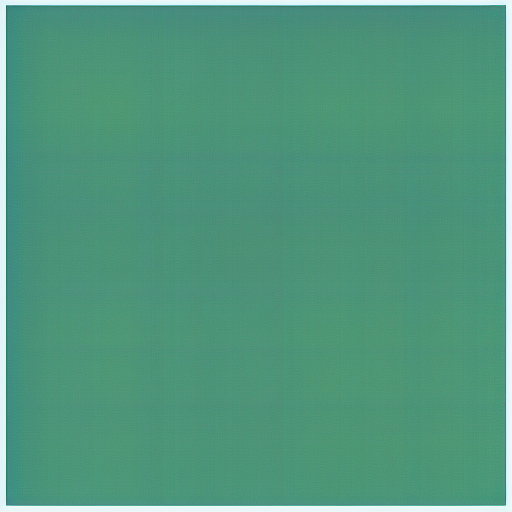

In [12]:
image_optimization(pipeline, img_source,"a pearson correlation matrix.", "a pearson correlation matrix.", img_target, num_iters=100, use_dds=False)